# Adding Gravity to Image Based Drainage Simulations

```{post} 2022-02-09
:tags: porespy
:redirect: porespy-drainage-w-gravity-intro
```


The PMEAL team recently developed a way to add gravitational effects to the standard drainage simulation algorithm based on sphere insertion, also sometimes called *morphological image opening* or *full morphology*. The paper is available in Water Resources Research. This post will give a brief overview of how to use this new algorithm, which is being included in a new function called ``drainage`` located in the also newly added ``porespy.simulations`` module.  The new ``drainage`` function can produce results with or without gravity effects, creating a more powerful yet flexible function for performing such simulations.

In [1]:
import porespy as ps
import numpy as np
import matplotlib.pyplot as plt
from edt import edt

Start by generating a 2D image of blobs:

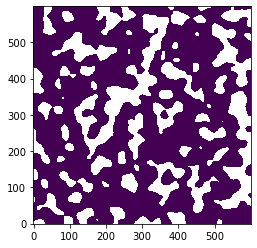

In [2]:
im = ps.generators.blobs([600, 600], porosity=0.7, blobiness=1.5)
ps.imshow(im);

First we'll compute a reference capillary pressure curve with no gravity effects using the new ``drainage`` function. This function requires us to supply an image of capillary pressure values associated with each voxel.  Typicall one would use the Washburn equation:

$$ P_C = -2\sigma \cos (\theta) \bigg(\frac{1}{r}\bigg) $$ 

where ``r`` is conveniently provided by the distance transfer.  This can be computed as follows:

In [3]:
voxel_size = 1e-4
dt = edt(im)
pc = -2*0.072*np.cos(np.deg2rad(180))/(dt*voxel_size)

The reason for requiring ``pc`` instead of just the boolean ``im`` is to allow users to compute the capillary pressure using any method they wish.  For instance a 2D image of a glass micromodel has a spacing between the plates which can be accounted for as:

$$ P_C = -\sigma \cos (\theta) \bigg(\frac{1}{r} + \frac{1}{s}\bigg) $$

Note that ``s`` could be set to ``np.inf`` for a 2D simulation.  Computing ``pc`` externally also reduces the number of arguments that must be sent to the function, by eliminating the surface tension and contact angles. 

In any event, the function is called as follows:

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

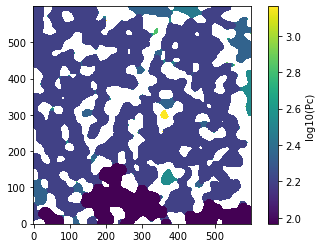

In [4]:
inlets = np.zeros_like(im)
inlets[0, ...] = True
drn = ps.simulations.drainage(pc=pc, im=im, inlets=inlets, voxel_size=voxel_size, g=0)
ps.imshow(np.log10(drn.im_pc))
cbar = plt.colorbar()
cbar.set_label('log10(Pc)');

The above image is colored according to the capillary pressure at which a given voxel was invaded. Note that we have applied a base-10 logarithm to the values to improve visibility.  This format is handy since it contains the entire invasion sequence in a single image.  Next let's plot the capillary pressure curve.  There are some functions available in ``porespy.metrics`` for this, but the ``drainage`` function actually does it for us and attaches the result to the returned object:

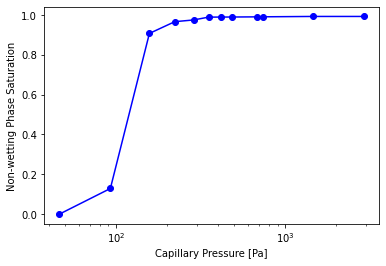

In [5]:
plt.semilogx(drn.pc, drn.snwp, 'b-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-wetting Phase Saturation');

Now let's perform the same experiment but including the gravity effects:

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

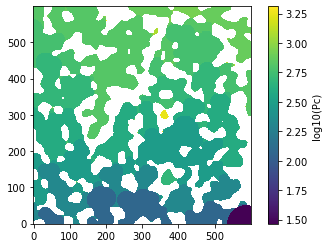

In [6]:
drn2 = ps.simulations.drainage(pc=pc, im=im, inlets=inlets, voxel_size=voxel_size, g=9.81)
ps.imshow(np.log10(drn2.im_pc))
cbar = plt.colorbar()
cbar.set_label('log10(Pc)');

We can see from the colormap that the invasion pattern is different.  Plotting the capillary pressure curve will make the differences more obvious:

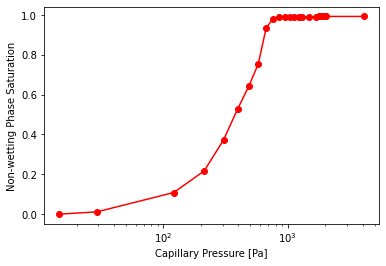

In [7]:
plt.semilogx(drn2.pc, drn2.snwp, 'r-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-wetting Phase Saturation');

Combining both plots together for a better comparison:

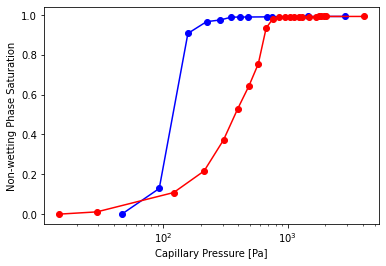

In [8]:
plt.semilogx(drn.pc, drn.snwp, 'b-o')
plt.semilogx(drn2.pc, drn2.snwp, 'r-o')
plt.xlabel('Capillary Pressure [Pa]')
plt.ylabel('Non-wetting Phase Saturation');

The red curve above is shifted to the right with a lower slope.  This is the expected result since the impact of gravity makes it more difficult for the heavy non-wetting fluid to rise up the domain and penetrate into pores. The decresed slope is also expected since pores are invaded more gradually rather than in a larger percolation event.